# 1. Convolutional AutoEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
# 평가 지표로 활용하기 위해서.
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [4]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


### Define Network

In [7]:
from IPython.display import Image

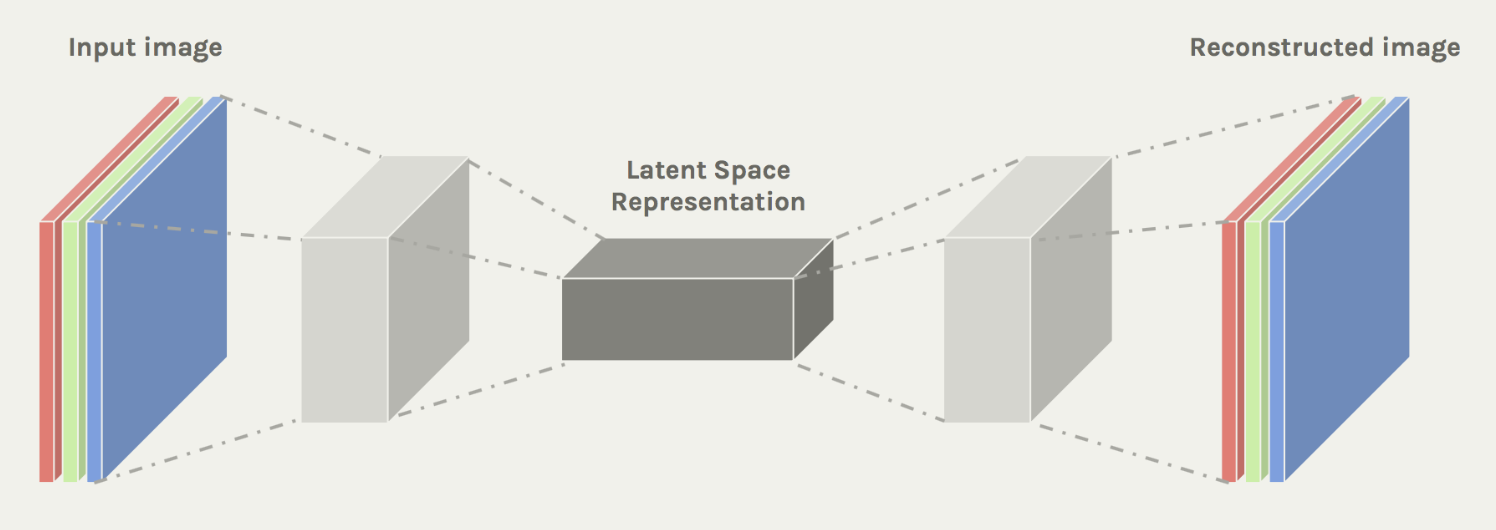

In [8]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/cae.png')

* Convolution

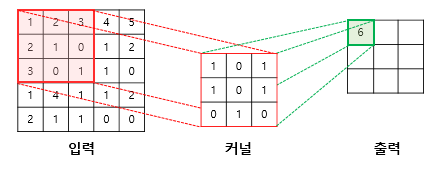

In [9]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/Conv.png')

* Transposed Convolution

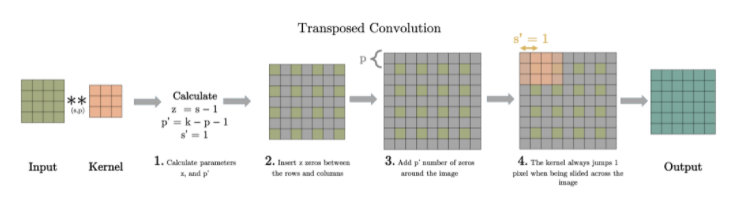

In [10]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/03/tconv.png')

In [11]:
class ConvAutoencoder(Model):

  def __init__(self):
    super(ConvAutoencoder, self).__init__() # 파생 클래스와 self

    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      # 28x28 사이즈의 Input Image를 14x14 사이즈의 Image로 압축
      # padding='same'으로 설정하면 conv연산시 feature map 크기가 줄어들지 않는다.
      # 여기서는 conv 연산 이후 feature map 크기는 줄지 않지만, stride로 절반으로 줄어든다.
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

convautoencoder = ConvAutoencoder()

In [12]:
convautoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

### Train Model

In [ ]:
convautoencoder.fit(x_train, x_train,
                    epochs=10,
                    shuffle=True,
                    validation_data=(x_test, x_test))

### Test Model

In [ ]:
conv_encoded_imgs = convautoencoder.encoder(x_test).numpy()
conv_decoded_imgs = convautoencoder.decoder(conv_encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # Original Image 시각화
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Reconstructed Image 시각화
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(conv_decoded_imgs[i].reshape(28, 28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# 2. Application: Image denoising

* 실행 구간 먼저 실행

1. 각 이미지에 Random Noise를 적용하여 Fashion MNIST Dataset의 Noise가 추가된 이미지 생성
2. Noise가 추가된 이미지를 Input으로, 원본 이미지를 Target으로 하여 Noise가 제거되도록 훈련

In [13]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [14]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


### Add Random Noise

In [ ]:
tf.random.normal(shape=x_train.shape)

In [ ]:
noise_factor = 0.2
# tf.random.normal을 통해 Normal Distribution으로부터 추출된 랜덤 노이즈 추가
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

# tf.clip_by_value를 통해 noisy가 추가된 픽셀 값의 최솟값을 0, 최댓값을 1로 제한
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [ ]:
# 노이즈가 추가된 이미지 시각화
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(x_test_noisy[i])
    plt.gray()
plt.show()

### Train Model

In [ ]:
class Denoise(Model):
    """
    Encoder: 2개의 Conv layer로 이루어진 이미지 압축 Network
    Decoder: 2개의 Transposed conv layer와 1개의 Conv layer로 이루어진 이미지 재구축 Network
    """

    def __init__(self):
        super(Denoise, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

* 파라미터 계산이 궁금한 분들을 위해

In [ ]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/ae.png')

In [ ]:
autoencoder.encoder.summary()
print('3*3*16 + 16 = ',3*3*16 + 16, 'params' ) 
print('16*3*3*8 + 8 = ',16*3*3*8 + 8, 'params' )

In [ ]:
autoencoder.decoder.summary()
print('8*3*3*8 + 8 = ', 8*3*3*8 + 8, 'params')
print('8*3*3*16 + 16 = ', 8*3*3*16 + 16, 'params')
print('16*3*3*1 + 1 = ', 16*3*3*1 + 1, 'params')

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(30, 6))

for i in range(n):

    # Noise가 추가된 Image (input, x) 시각화
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Original Image (target, y) 시각화
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("original")
    plt.imshow(x_test[i])
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    
    # Reconstructed Image (prediction) 시각화
    cx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)

plt.show()

# 3. Application: Anomaly Detection

ECG5000 Dataset
- 140개의 Data Point를 가지는 5,000개의 심전도 데이터
- Label: 비정상 0, 정상 1
---
Anomaly Detection with AutoEncoder
- 가설: 정상 데이터로 훈련된 AutoEncoder에 비정상 데이터가 통과하면 Reconstruction Error가 클 것
1. 정상 데이터로만 훈련한 후 해당 AutoEncoder에 모든 Test data를 재구성 
2. 재구성 오류가 어떤 임계값을 초과하는 경우 이상으로 분류




### Load Data

In [16]:
# 실습에 필요한 데이터를 googleapis의 storage에서 불러옴
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
# dataframe 형태의 데이터를 array 형태로 변환
raw_data = dataframe.values

In [17]:
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [18]:
dataframe[140].unique()

array([1., 0.])

In [19]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [20]:
dataframe.describe()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,...,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,-0.262502,-1.649828,-2.492623,-3.119754,-3.167656,-2.866306,-2.272845,-1.797754,-1.409784,-0.935806,...,0.071312,-0.062622,-0.276086,-0.507750,-0.761323,-0.835173,-0.642739,-0.487667,-0.706574,0.584034
std,1.152450,1.445542,1.386457,1.302921,1.104535,0.906312,0.731594,0.622794,0.636863,0.657788,...,1.404425,1.646105,1.894515,2.059366,2.086130,2.056296,1.859409,1.831088,1.414414,0.492937
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,...,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227,0.000000
25%,-1.004220,-2.701936,-3.668585,-4.227337,-4.007630,-3.480666,-2.779832,-2.165808,-1.773870,-1.362003,...,-1.087720,-1.588237,-2.146835,-2.730750,-3.031224,-2.868603,-2.154560,-1.658289,-1.596809,0.000000
50%,-0.297541,-1.661892,-2.586129,-3.388210,-3.469899,-2.947061,-2.285427,-1.750084,-1.422457,-0.910384,...,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.568443,1.000000
75%,0.499909,-0.677998,-1.514187,-2.235690,-2.531153,-2.398797,-1.823480,-1.484107,-1.063592,-0.476477,...,1.169392,1.238651,1.264379,1.234408,1.033957,0.945027,0.951621,1.002628,0.271635,1.000000
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,1.898627,...,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103,1.000000


### Train Test Split

In [21]:
raw_data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.92528624,
         0.19313742,  1.        ],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  1.1196209 ,
        -1.4362499 ,  1.        ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.90422673,
        -0.42179659,  1.        ],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.0083694 ,
        -1.8083338 ,  0.        ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.1504486 ,
         0.80493225,  0.        ],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -1.577823  ,
        -0.68453092,  0.        ]])

In [22]:
labels = raw_data[:, -1]
# label만 가져오기
data = raw_data[:, 0:-1]
# label을 제외한 전체 데이터 가져오기

In [23]:
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [24]:
data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.12343082,
         0.92528624,  0.19313742],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  0.77381971,
         1.1196209 , -1.4362499 ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.32109663,
         0.90422673, -0.42179659],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.874136  ,
        -2.0083694 , -1.8083338 ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.261335  ,
         1.1504486 ,  0.80493225],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -2.2600228 ,
        -1.577823  , -0.68453092]])

In [25]:
print(data.shape, labels.shape)

(4998, 140) (4998,)


In [26]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [27]:
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(3998, 140) (3998,) (1000, 140) (1000,)


### Data Normalization [0, 1]

Normalization 이유
- 큰 값을 갖는 변수에 편향되는 것을 막기 위해
- 손실 함수의 표면을 매끄럽게 하고 빠른 최적화를 위해

In [28]:
# minmaxnormalization
min_val = tf.reduce_min(train_data) 
# 최소값 
max_val = tf.reduce_max(train_data)
# 최대값

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
# float32 형태로 변형

- Train: Normal
- Test: Normal and Abnormal

In [29]:
train_labels

array([1., 1., 1., ..., 1., 1., 1.])

In [30]:
train_labels = train_labels.astype(bool)
# bool : True, False
test_labels = test_labels.astype(bool)
# bool : True, False

In [31]:
train_labels

array([ True,  True,  True, ...,  True,  True,  True])

In [32]:
test_labels

array([ True, False,  True,  True, False,  True,  True,  True, False,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True, False,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True, False, False, False,
        True, False,  True,  True, False,  True, False,  True,  True,
       False, False,  True, False, False,  True,  True, False,  True,
       False, False,  True, False, False,  True,  True,  True,  True,
       False, False,  True,  True,  True, False, False, False,  True,
        True, False, False, False,  True, False,  True, False, False,
        True, False,  True, False,  True,  True,  True, False,  True,
       False,  True,  True,  True, False,  True, False,  True,  True,
       False, False,  True, False,  True,  True,  True, False,  True,
       False,  True,

In [33]:
# train_data[train_labels]는 train_data[train_labels=True]와 동일 → Normal Data 추출
normal_train_data = train_data[train_labels]
# True인 data만 남는다.
normal_test_data = test_data[test_labels]

In [34]:
# ~train_labels를 통해 train_labels가 False인 (즉, Anomaly인) Data 추출
anomalous_train_data = train_data[~train_labels]
# False인 data만 남는다.
anomalous_test_data = test_data[~test_labels]

### Visualization of Normal Data

* 정상적인 심전도 데이터

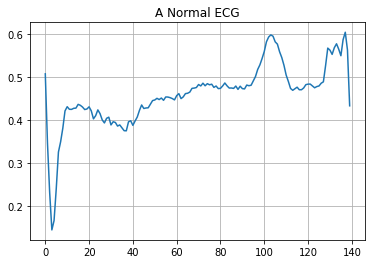

In [35]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[3])
plt.title("A Normal ECG")
plt.show()

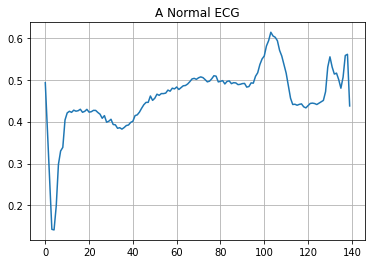

In [36]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[4])
plt.title("A Normal ECG")
plt.show()

In [37]:
max(normal_train_data[4])

<tf.Tensor: shape=(), dtype=float32, numpy=0.6131052>

In [38]:
min(normal_train_data[4])

<tf.Tensor: shape=(), dtype=float32, numpy=0.14176697>

### Visualization of Abnormal Data

* 비정상적인 심전도 데이터

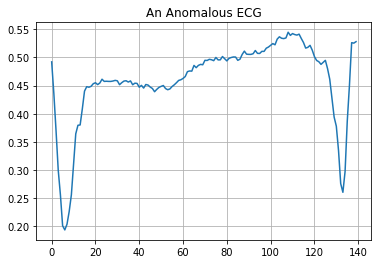

In [39]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[2])
plt.title("An Anomalous ECG")
plt.show()

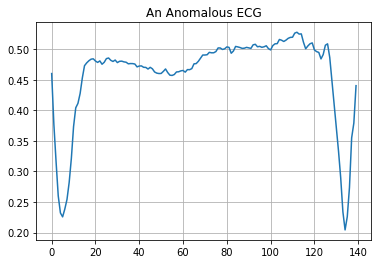

In [40]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[4])
plt.title("An Anomalous ECG")
plt.show()

In [41]:
max(anomalous_train_data[4])

<tf.Tensor: shape=(), dtype=float32, numpy=0.52760214>

In [42]:
min(anomalous_train_data[4])

<tf.Tensor: shape=(), dtype=float32, numpy=0.20430082>

### Build AutoEncoder Model

* 위와 동일한 AutoEncoder Model 여기서는 올바른 심전도만을 학습시켜 정상데이터만 정확하게 복원하도록 학습

In [43]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()

    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [44]:
autoencoder.compile(optimizer='adam', loss='mae')

### Train AutoEncoder Model

In [45]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=50, 
          batch_size=128,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
19/19 [==============================] - 4s 20ms/step - loss: 0.0534 - val_loss: 0.0471
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0354 - val_loss: 0.0386
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0355
Epoch 4/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0223 - val_loss: 0.0338
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0206 - val_loss: 0.0337
Epoch 6/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0204 - val_loss: 0.0333
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0203 - val_loss: 0.0329
Epoch 8/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0202 - val_loss: 0.0326
Epoch 9/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0200 - val_loss: 0.0318
Epoch 10/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0199 - val_loss: 0.0312
Epoch 11/50
19/19 

* 학습이 잘 된 것을 확인

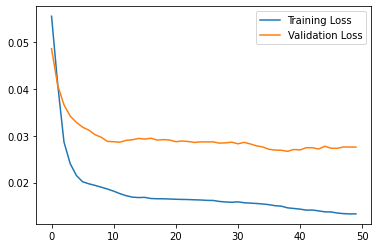

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Visualization of Reconstruction Error of Normal Test Sample Data

- Normal 데이터이기 때문에 Input과 Reconstruction 사이 면적(즉, Reconstruction Error)이 작을 것으로 예상됨

In [ ]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
# noral_test_data를 encoder에 입력 : latent vector
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
# latent vector를 decoder에 입력 : 복원 이미지

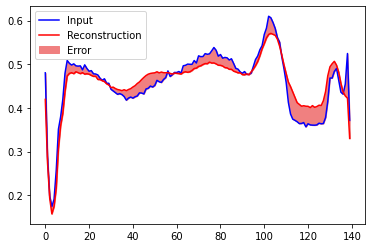

In [ ]:
plt.plot(normal_test_data[0], 'b')
# 정상 데이터 : 원본 
plt.plot(decoded_imgs[0], 'r')
# decoded_imgs : 복원 
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
# 차이를 채워주는 함수
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Visualization of Reconstruction Error of Abnormal Test Sample Data

- Abnormal 데이터이기 때문에 Input과 Reconstruction 사이 면적(즉, Reconstruction Error)이 클 것으로 예상됨

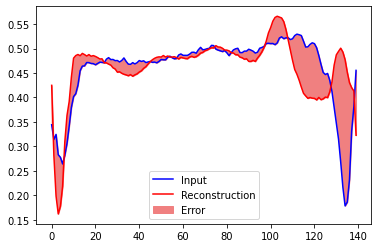

In [ ]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
# 비정상데이터
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
# 비정상 데이터를 복원한 데이터

plt.plot(anomalous_test_data[2], 'b')
plt.plot(decoded_imgs[2], 'r')
plt.fill_between(np.arange(140), decoded_imgs[2], anomalous_test_data[2], color='lightcoral')
# 차이를 채워주는 함수
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

→ 눈으로 보아도 정상 데이터보다 비정상데이터의 Error가 크다는 걸 알 수 있다.

### Distribution of Reconstruction Error of (Normal) Train Data

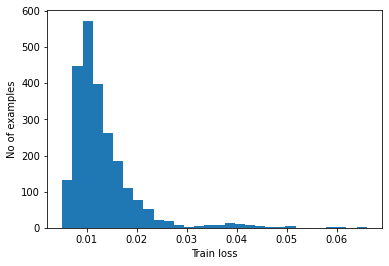

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
# 정상데이터와 복원한 데이터의 mae

plt.hist(train_loss, bins=30)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

- Reconstruction Error가 고정 임계값보다 큰지 여부에 따라 이상을 탐지
- 임계값은 Task에 따라 다양한 방법으로 설정 가능
- 해당 문제에서는 '(Normal) Train Data Reconstruction Error의 평균 + 표준편차'를 임계값으로 설정

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.019719234


### Distribution of Reconstruction Error of Normal Test Data

* 정상/비정상을 나누는 임계값을 위의 Threshold로 지정하고 아래의 그래프를 보자.

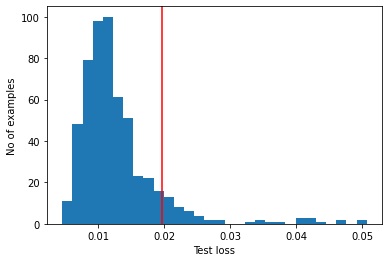

In [ ]:
reconstructions = autoencoder.predict(normal_test_data)
# 정상 데이터
test_loss = tf.keras.losses.mae(reconstructions, normal_test_data)
# 정상 데이터와 복원 데이터의 mae

plt.hist(test_loss, bins=30)
plt.xlabel('Test loss')
plt.ylabel('No of examples')
plt.axvline(x=threshold, ymin=0.0, ymax=80, c='red')

plt.show()

### Distribution of Reconstruction Error of Abnormal Test Data

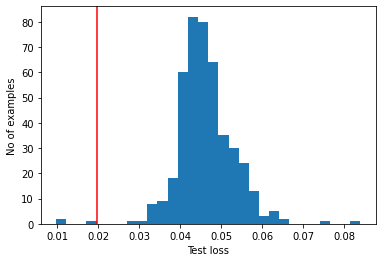

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
# 비정상 데이터
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
# 비정상 데이터와 그 복원 데이터의 mae

plt.hist(test_loss, bins=30)
plt.xlabel('Test loss')
plt.ylabel('No of examples')
plt.axvline(x=threshold, ymin=0.0, ymax=80, c='red')

plt.show()

- Threshold를 기준으로 보았을때 Reconstruction Error (= Loss = Anomaly Score)의 분포가 확연히 차이나는 것을 알 수 있음

### Final Anomaly Detection and Evaluation

In [ ]:
def predict(model, data, threshold):
    # model, data, threshold를 input
    reconstructions = model(data)
    # data를 model에 입력하여 복원
    loss = tf.keras.losses.mae(reconstructions, data)
    # 복원한 것과 실제 데이터의 mae
    return tf.math.less(loss, threshold)
    # tf.math.less를 통해 loss < threshold 이면 Normal로 예측

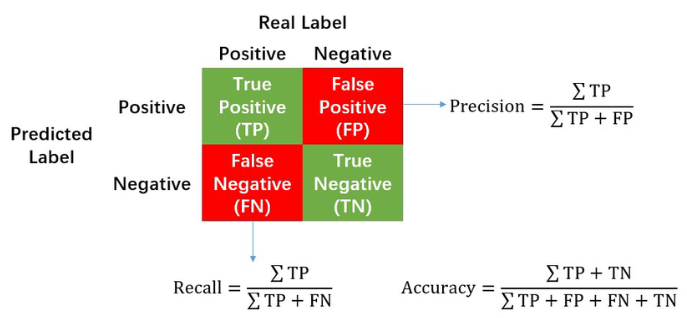

In [ ]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/cfm.png')

* 지금 문제에서 Positive는 정상(=1) Negative는 비정상(=0)이다.

In [ ]:
def print_stats(predicts, labels):
    print('Accuracy = {}'.format(accuracy_score(labels, preds)))
    print('Precision = {}'.format(precision_score(labels, preds)))
    print('Recall = {}'.format(recall_score(labels, preds)))
    print('Confusion Matrix = {}'.format(confusion_matrix(labels, preds)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.946
Precision = 0.994140625
Recall = 0.9089285714285714
Confusion Matrix = [[437   3]
 [ 51 509]]
